<a href="https://colab.research.google.com/github/mounishsjsu/266_Project/blob/master/266_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5f8e075370829382bcb7684d2a7a2d725feabd67feebd699c50c7b5925daab5b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,SQLContext
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd
import plotly.graph_objects as go
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType
import seaborn as sns
import re
from textblob import TextBlob

In [ ]:
conf = SparkConf().setMaster("local").setAppName("Weather analysis")
from sklearn.metrics import mean_squared_error      #for reading & storing data, pre-processing
pd.set_option('display.float_format', lambda x: '%.5f' % x)

sc = SparkContext(conf = conf)
spark = SparkSession(sc)

sqlContext = SQLContext(sc)

In [ ]:
df = spark.read.option("header",'true').csv("/content/city_temperature.csv",inferSchema=True)

NameError: name 'spark' is not defined

In [ ]:
print(df.head(3))

In [ ]:
print(df.dtypes)

#Convert the data into a pandas dataframe
df=df.toPandas()

#Choosing only the rows with India from the dataframe
data_India  = df[ (df['Country'] == 'India') & (df['Year'] < 2020)]


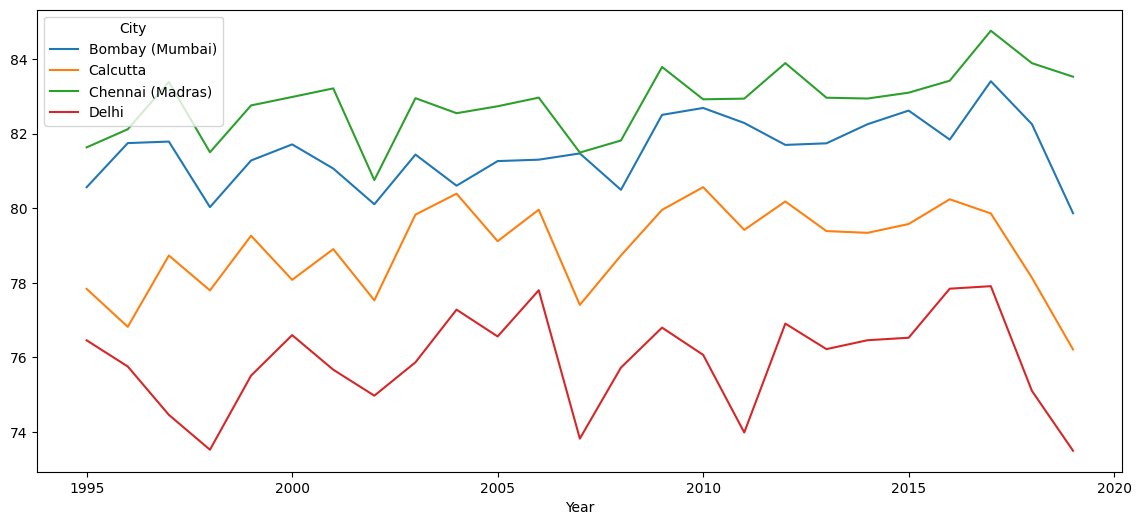

In [ ]:
India_plot=data_India.groupby(['City','Year'])['AvgTemperature'].mean().reset_index()
India_plot.pivot('Year','City','AvgTemperature').plot()
plt.gcf().set_size_inches(14,6)
fig1= plt.savefig("/content/Screenshots")
plt.show()

In [ ]:
def season(df):
    if df in [12,1,2] :
        return 'Winter'
    elif  df in [3,4,5]:
        return 'Summer'
    elif df in [6,7,8]:
        return 'Monsoon'
    elif df in [9,10,11]:
        return 'Autumn'
    else:
        return 'NA'


In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
data_India['Season'] = data_India['Month'].apply(season)

data_India['AvgTemperature']=data_India['AvgTemperature'].astype('float64')
data_India[['Month' , 'Day' , 'Year']]=data_India[['Month' , 'Day' , 'Year']].astype('int64')

#Seasons in Delhi
data_Delhi = data_India[data_India['City'] == 'Delhi']

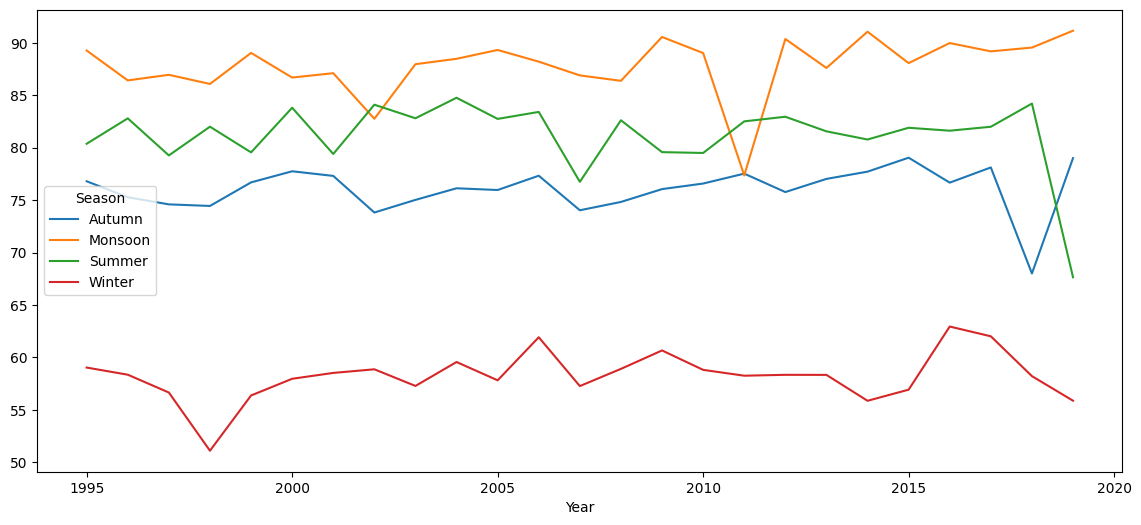

In [ ]:
Delhi_plot=data_Delhi.groupby(['Season','Year'])['AvgTemperature'].mean().reset_index()
Delhi_plot.pivot('Year','Season','AvgTemperature').plot()
plt.gcf().set_size_inches(14,6)
fig2= plt.savefig("/content/Screenshots")
plt.show()

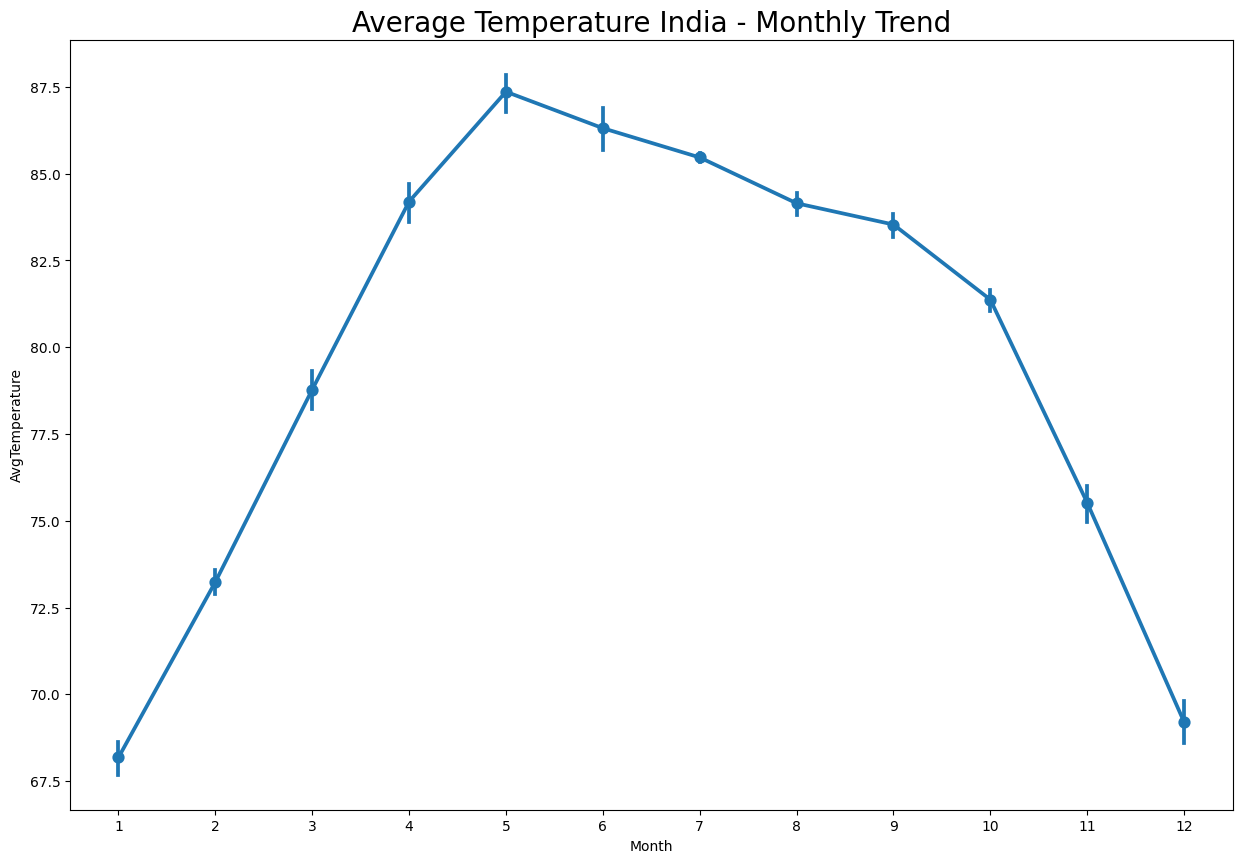

In [ ]:
plt.figure(figsize= (15,10))
sns.pointplot(x='Month', y='AvgTemperature', data=data_India);
plt.title('Average Temperature India - Monthly Trend',fontsize=20);

In [ ]:
Average_Temperture_in_every_region = df.groupby("Region")["AvgTemperature"].mean().sort_values()[-1::-1]
Average_Temperture_in_every_region = Average_Temperture_in_every_region.rename({"South/Central America & Carribean":"South America","Australia/South Pacific":"Australia"})
Average_Temperture_in_every_region

Region
Middle East     68.38455
Asia            62.56865
South America   62.18944
Australia       61.18087
North America   55.30093
Africa          53.54952
Europe          46.69629
Name: AvgTemperature, dtype: float64

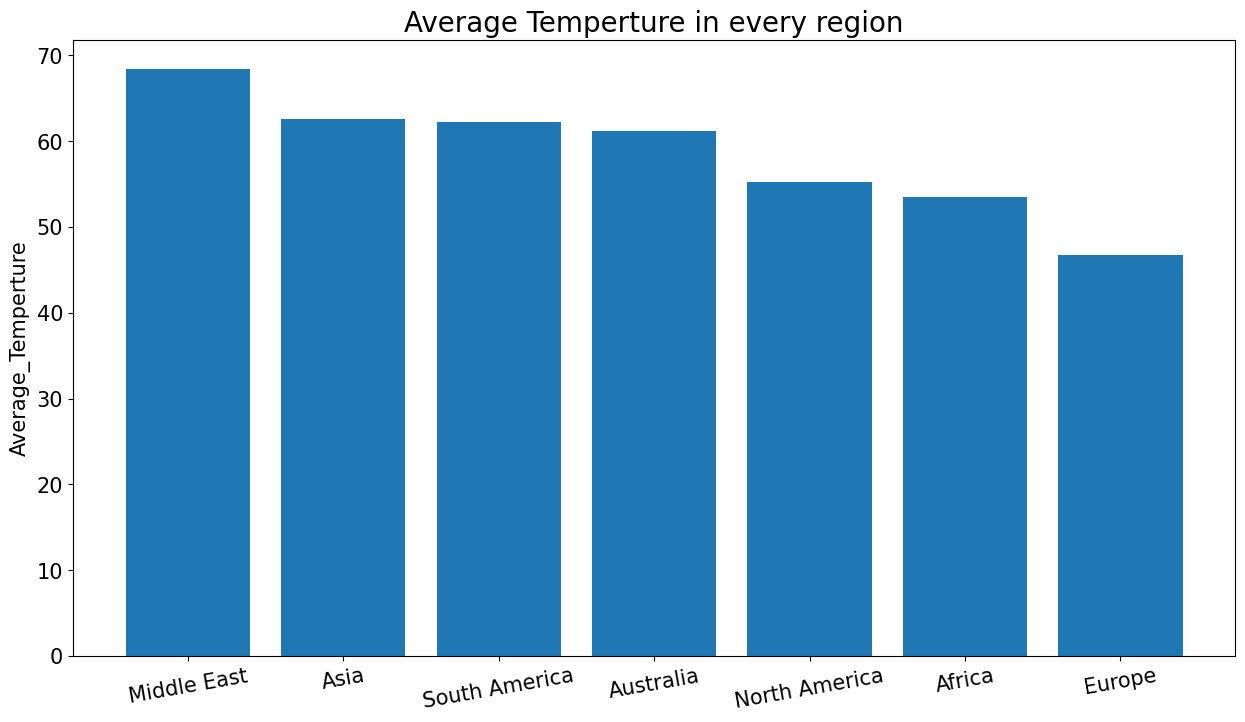

In [ ]:
fig3= plt.figure(figsize = (15,8))
plt.bar(Average_Temperture_in_every_region.index,Average_Temperture_in_every_region.values)
plt.xticks(rotation = 10,size = 15)
plt.yticks(size = 15)
plt.ylabel("Average_Temperture",size = 15)
plt.title("Average Temperture in every region",size = 20)
fig3= plt.savefig("/content/Screenshots")
plt.show()

In [ ]:
df.drop('State',axis='columns', inplace=True)

#Keeping only rows for Delhi
delhi = df[df["City"] == "Delhi"]
delhi.reset_index(inplace = True)
delhi.drop('index', axis = 1, inplace=True)
print(delhi.describe())


           Month        Day       Year  AvgTemperature
count 9265.00000 9265.00000 9265.00000      9265.00000
mean     6.46908   15.71765 2007.18683        75.79886
std      3.45748    8.80195    7.32454        19.31898
min      1.00000    1.00000 1995.00000       -99.00000
25%      3.00000    8.00000 2001.00000        65.00000
50%      6.00000   16.00000 2007.00000        80.50000
75%      9.00000   23.00000 2014.00000        87.50000
max     12.00000   31.00000 2020.00000       103.70000


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
delhi["AvgTemperature"].replace(-99, np.mean(delhi["AvgTemperature"]), inplace = True)
delhi["AvgTemperature"] = pd.DataFrame(imputer.fit_transform(delhi.loc[:, "AvgTemperature":]))

In [ ]:
print(delhi.columns)

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature'], dtype='object')


   Year  AvgTemperature       Date
0  1995        50.70000 1995-01-01
1  1995        52.10000 1995-01-02
2  1995        53.80000 1995-01-03
3  1995        53.70000 1995-01-04
4  1995        54.50000 1995-01-05


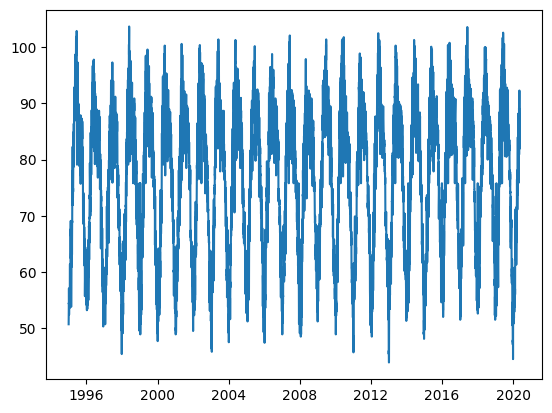

In [ ]:
#Converting to datetime format
delhi['Date'] = pd.to_datetime(delhi[['Year','Month','Day']])
delhi = delhi.drop(['Region', 'Country', 'City','Month','Day'], axis = 1)
print(delhi.head())

#Visualisation
fig4= plt.plot(delhi["Date"], delhi["AvgTemperature"])
fig4=plt.savefig("/content/Screenshots")
plt.show()

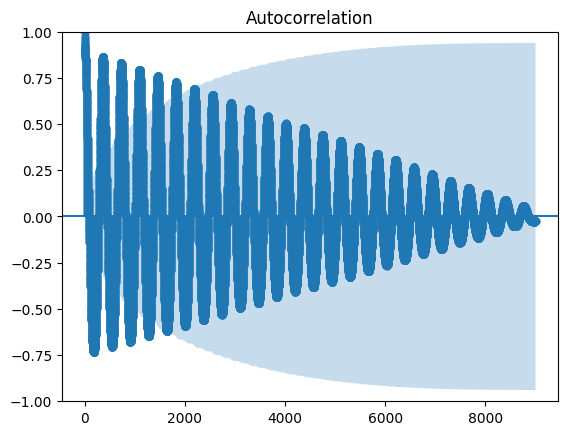

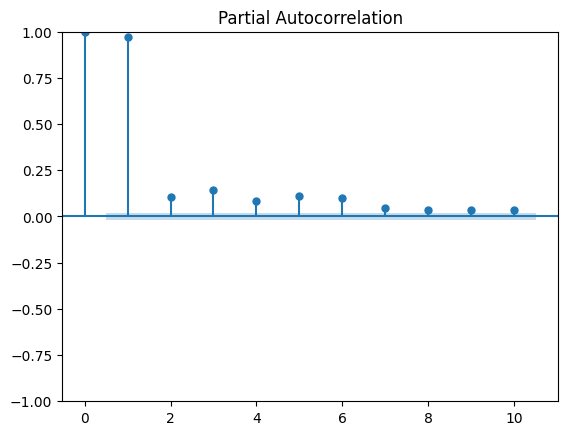

In [ ]:
training_set = delhi[delhi["Year"] <= 2015]
test_set = delhi[delhi["Year"] > 2015]

#acf and pacf plots
from statsmodels.graphics.tsaplots import plot_acf
acf=plot_acf(delhi["AvgTemperature"], lags = 9000)
from statsmodels.graphics.tsaplots import plot_pacf
pacf=plot_pacf(delhi["AvgTemperature"], lags = 10)
fig5=plt.savefig("/content/Screenshots")
plt.show()

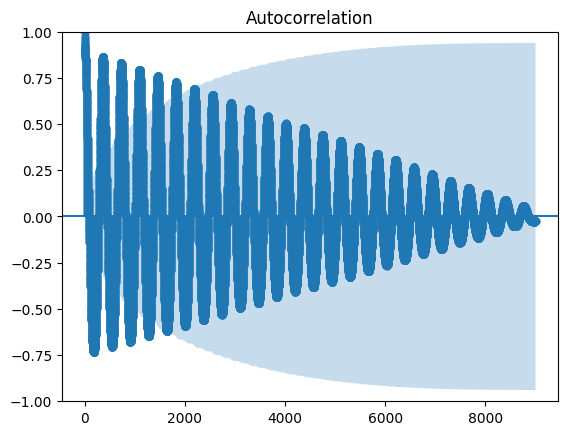

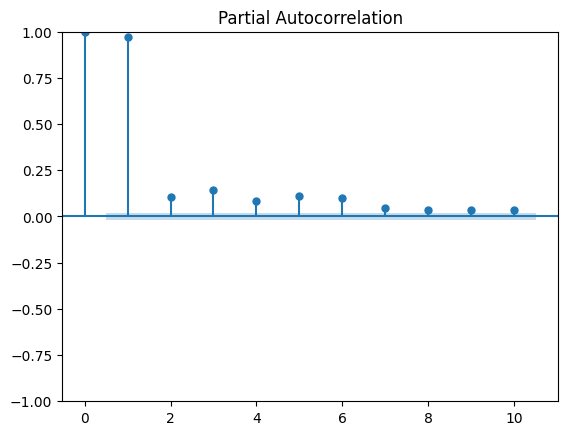

In [ ]:
#Defining training and testing data
training_set = delhi[delhi["Year"] <= 2015]
test_set = delhi[delhi["Year"] > 2015]

#acf and pacf plots
from statsmodels.graphics.tsaplots import plot_acf
acf=plot_acf(delhi["AvgTemperature"], lags = 9000)
from statsmodels.graphics.tsaplots import plot_pacf
pacf=plot_pacf(delhi["AvgTemperature"], lags = 10)
fig5=plt.savefig("/content/Screenshots")
plt.show()

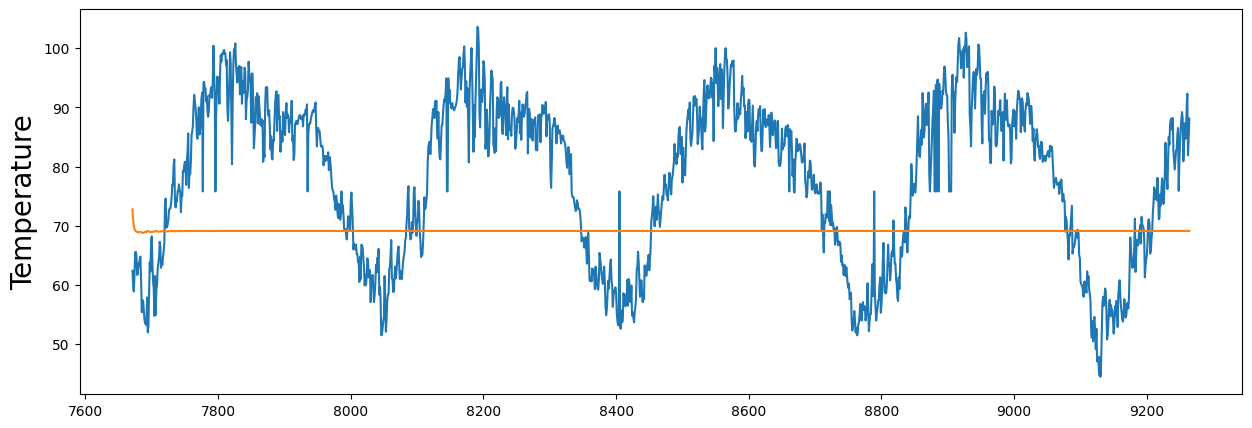

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMA = SARIMAX(training_set["AvgTemperature"], order=(2, 1, 3), seasonal_order=(1, 0, 2, 12))
model_fit_MA = model_SARIMA.fit()
predictions_MA = model_fit_MA.predict(test_set.index[0],test_set.index[-1])

fig5=plt.figure(figsize=(15,5))
plt.ylabel("Temperature",fontsize=20)
plt.plot(test_set["AvgTemperature"],label="Original Data")
plt.plot(predictions_MA,label="Predictions")
fig6=plt.savefig("/content/Screenshots")
plt.show()

In [ ]:
#RMSE for MA model
mse = mean_squared_error(predictions_MA,test_set["AvgTemperature"])
print(mse**0.5)

15.899385127950122


In [ ]:
#AR model
from statsmodels.tsa.ar_model import AutoReg
model_AR = AutoReg(training_set["AvgTemperature"], lags = 1000)
model_fit_AR = model_AR.fit()
predictions_AR = model_fit_AR.predict(training_set.shape[0], training_set.shape[0] + test_set.shape[0] - 1)

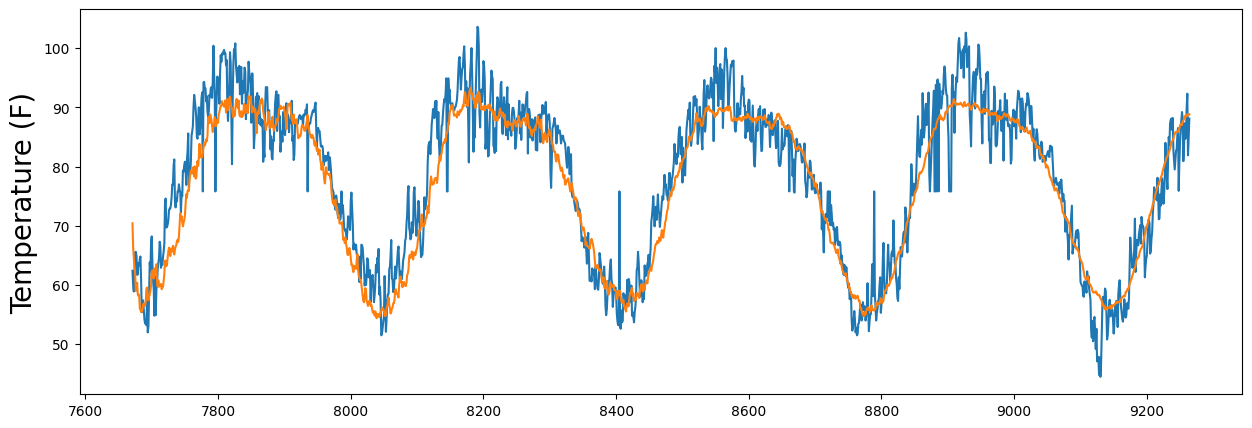

In [ ]:
import seaborn as sns
fig6= plt.figure(figsize=(15,5))
plt.ylabel("Temperature (F)", fontsize = 20)
plt.plot(test_set["AvgTemperature"], label = "Original Data")
plt.plot(predictions_AR, label = "Predictions")
fig7=plt.savefig("/content/Screenshots")
plt.show()

In [ ]:
rmse = mean_squared_error(predictions_AR,test_set["AvgTemperature"])
print(rmse**0.5)

4.88872467947809
